In [1]:
import os
import numpy as np
import pandas as pd
import nltk
from nltk.util import ngrams
from nltk.tokenize.treebank import TreebankWordDetokenizer, TreebankWordTokenizer
import spacy
import matplotlib.pyplot as plt
import tqdm
from datetime import datetime  
from datetime import timedelta
import statistics

Import the cleaned data.

In [2]:
def find(name, path):
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)

In [45]:
path = find('ProcessedCleanedScraper.xlsx','C://')
data = pd.read_excel(path)

Create columns for metadata on the industries, nation, number of documents of the company and the dates.

In [46]:
data['SIC'] = ""
data['Deal Date'] = ""
data['Document Date'] = ""
data['Macro Industry'] = ""
data['Mid Industry'] = ""
data['Nation'] = ""
data['Doc count'] = ""


Iterate over the cleaned data and add this metadata to each row.

In [47]:
for index, row in data.iterrows():
    data.at[index, 'Deal Date'] = str(data.iloc[index]['Date Effective'])[0:4] + '-' + str(data.iloc[index]['Date Effective'])[4:6] +'-'+str(data.iloc[index]['Date Effective'])[6:8]
    data.at[index, 'Document Date'] = str(data.iloc[index]['companydate'][-8:-4]) +'-'+ str(data.iloc[index]['companydate'][-4:-2])+'-'+str(data.iloc[index]['companydate'][-2::])
    comptype =data.iloc[index]['companytype']
    if comptype == 'Target':
        sic = data.iloc[index]['Target Primary SIC Code']
        macro = data.iloc[index]['Target Macro Industry']
        mid = data.iloc[index]['Target Mid Industry']
        nation = data.iloc[index]['Target Nation']
    if comptype == 'Acquiror':
        sic = data.iloc[index]['Acquiror Primary SIC Code']
        macro = data.iloc[index]['Acquiror Macro Industry']
        mid = data.iloc[index]['Acquiror Mid Industry']
        nation = data.iloc[index]['Acquiror Nation']
    data.at[index, 'SIC'] = sic
    data.at[index, 'Macro Industry'] = macro
    data.at[index, 'Mid Industry'] = mid
    data.at[index, 'Nation'] = nation
    

Count the number of documents for a company and add this to the metadata.

In [48]:
for value in data['companydate'].unique():
    datasubset = data[data['companydate']==value]
    counter = datasubset.shape[0]
    indices = datasubset.index
    for index in indices:
        data.at[index, 'Doc count'] = int(counter)

Check if the crawled URLs satisfies one of these conditions. If that is the case, add the index of the instance to a list that contains indices which are subsequently dropped.

In [49]:
indices = list()
for index, rows in data.iterrows():
    site = data.iloc[index]['crawlurl'].lower()
    if ('about' in site) and ('us' in site):
        indices.append(index)
    if ('privacy') in site:
        indices.append(index)
    if ('career' in site):
        indices.append(index)
    if ('terms' in site):
        indices.append(index)
    if ('team' in site):
        indices.append(index)
    if ('relations' in site):
        indices.append(index)
    if ('director' in site):
        indices.append(index)
    if ('executive' in site):
        indices.append(index)
    if ('sitemap' in site):
        indices.append(index)
    if ('team' in site):
        indices.append(index)
    if('our' in site) and ('people' in site):
        indices.append(index)
    if('our' in site) and ('company' in site):
        indices.append(index)
    if('news' in site):
        indices.append(index)
    if ('contact' in site) and ('us' in site):
        indices.append(index)
    if ('article' in site):
        indices.append(index)
    if ('blog' in site):
        indices.append(index)
    if ('video' in site):
        indices.append(index)
    if ('investor' in site):
        indices.append(index)
    if ('job' in site):
        indices.append(index)
    if ('disclaimer' in site):
        indices.append(index)
    if ('legal' in site):
        indices.append(index)
    if ('partners' in site):
        indices.append(index)
        

In [50]:
data = data.drop(index=indices)

Reset the indices after dropping the invalid instances.

In [51]:
data = data.reset_index(drop=True)

Import the stop words.

In [86]:
stopwords = nltk.corpus.stopwords.words('english')
newstopwords = pd.read_csv('customstopwords.csv')
newstopwords = list(newstopwords['words'])
stopwords.extend(newstopwords)

Function that returns bigrams and trigrams of the unigrams in a sentence if the unigrams are not stopwords.

In [87]:
def word_grams(words, min=1, max=4):
    s = []
    words = TreebankWordTokenizer().tokenize(words)
    for n in range(min, max):
        for ngram in ngrams(words, n):
            stopword = False
            unique_words = []
            all_unique = True
            for word in ngram:
                if word not in unique_words:
                    unique_words.append(word)
                else:
                    all_unique=False
            if all_unique == True:
                if word in stopwords:
                    stopword = True
                if stopword == False:
                    s.append('_'.join(str(i) for i in ngram))
    s = TreebankWordDetokenizer().detokenize(s)
                
    return s

Add the text with bigrams and trigrams to a column called "Tokenized_texts"

In [88]:
data['Tokenized_texts'] = ""

In [89]:
indices = list()
for index, row in data.iterrows():
    text = data.iloc[index]['clean_text']
    if type(text) ==str:
        new_text = word_grams(text)
        if len(new_text)!=0 and (' ' in new_text):
            data.at[index, 'Tokenized_texts'] = new_text
        else:
            indices.append(index)
    else:
        indices.append(index)

In [91]:
data = data.drop(index=indices)

Add a column for the year and month in which the deal took place and the year and month of the scraping timestamp.

In [115]:
data['DealYearMonth'] = ""
data['DocumentYearMonth']=""

In [116]:
for index, row in data.iterrows():
    dealyearmonth = data.iloc[index]['Deal Date'][-7:-5]+data.iloc[index]['Deal Date'][-4::]
    documentyearmonth = data.iloc[index]['Document Date'][-7:-5] + data.iloc[index]['Document Date'][-4::]
    data.at[index, "DealYearMonth"]=dealyearmonth
    data.at[index, "DocumentYearMonth"]=documentyearmonth

Format the deal date and document date to date time objects.

In [108]:
data['Deal Date'] = pd.to_datetime(data['Deal Date'], format="%d/%m/%Y")
data['Document Date'] = pd.to_datetime(data['Document Date'], format='%d/%m/%Y')

Get sorted lists of all deal dates and document dates.

In [109]:
dealdates = list(data.sort_values(by='Deal Date')['Deal Date'])
documentdates = list(data.sort_values(by='Document Date')['Document Date'])

Find the earliest and latest date of deals. The earliest date gets the integer 1 associated with it. Per day, the count is incremented by 1. Each instance gets a deal date integer associated with it in this way.

In [110]:
firstdealdate = dealdates[0]
lastdealdate = dealdates[-1]
rangedates = lastdealdate - firstdealdate
data['DealDateInt'] = ""
for i in range(rangedates.days+1):
    datum= (dealdates[0] + timedelta(days=i)).date()
    subset = data[data['Deal Date']==datum]
    subsetindices = list(subset.index)
    for index in subsetindices:
        data.at[index, "DealDateInt"] = i

C:\Users\20150624\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.
  import sys


Find the earliest and latest date of the timestamps for scraping. The earliest date gets the integer 1 associated with it. Per day, the count is incremented by 1. Each instance gets a document date integer associated with it in this way.

In [111]:
firstdocdate = documentdates[0]
lastdocdate = documentdates[-1]
rangedates = lastdocdate - firstdocdate
data['DocumentDateInt'] = ""
for i in range(rangedates.days+1):
    datum = (documentdates[0] + timedelta(days=i)).date()
    subset = data[data['Document Date']==datum]
    subsetindices = list(subset.index)
    for index in subsetindices:
        data.at[index, "DocumentDateInt"] = i

C:\Users\20150624\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.
  import sys


Add an "A" to the healthcare industry to make it first in alphabetical lists.

In [112]:
data['Macro Industry'] = data['Macro Industry'].replace(regex="Healthcare", value="AHealthcare")

Create the deal year and document year by only keeping the year and getting rid of the month.

In [13]:
data['DealYear'] = ""
data['DocumentYear'] = ""
for index, row in data.iterrows():
    dealyearmonth = str(data.iloc[index]['DealYearMonth'])
    data.at[index, 'DealYear'] = dealyearmonth[-4:]
    documentyearmonth = str(data.iloc[index]['DocumentYearMonth'])
    data.at[index, 'DocumentYear'] = documentyearmonth[-4:]


Save the cleaned data with metadata.

In [16]:
data.to_csv('TokenizedAllScraper.csv')

Compute the average and median number of documents per company.

In [16]:
keepunique = data.drop_duplicates(['Target Name', 'Acquiror Name'])

In [22]:
sum(list(keepunique['Doc count']))/len(list(keepunique['Doc count']))

80.32336448598132

In [25]:
statistics.median(list(keepunique['Doc count']))

30

Get the number of documents per company+timestamp combination.

In [37]:
companydates = set(list(data['companydate'].values))
lengths = list()
for companydate in companydates:
    lengths.append(data[data['companydate']==companydate].shape[0])

In [44]:
sublength = [i for i in lengths if i<51]

Plot the number of documents per company+timestamp combination.

(array([874., 214.,  97.,  53.,  42.,  33.,  11.,  10.,   4.,   3.]),
 array([  1. ,  36.7,  72.4, 108.1, 143.8, 179.5, 215.2, 250.9, 286.6,
        322.3, 358. ]),
 <a list of 10 Patch objects>)

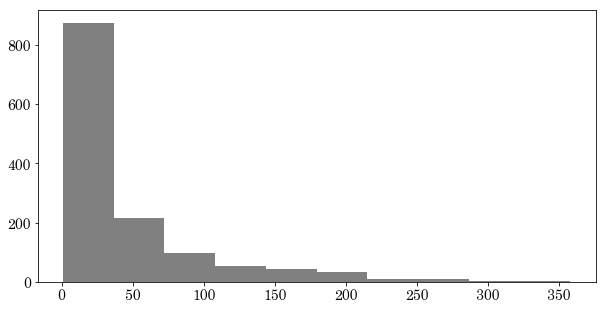

In [46]:
plt.figure(figsize=(10,5))
plt.xticks(fontname="century", fontsize=14)
plt.yticks(fontname="century", fontsize=14)
plt.hist(lengths, color="gray")

Plot the number of documents per company+timestamp combination for instances with at most 50 documents.

(array([481.,  90.,  74.,  50.,  70.,  66.,  37.,  36.,  39.,  33.]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ]),
 <a list of 10 Patch objects>)

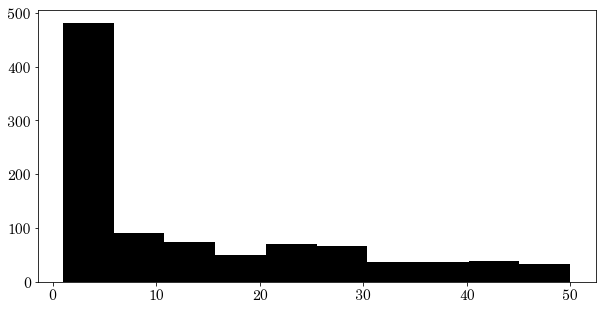

In [45]:
plt.figure(figsize=(10,5))
plt.xticks(fontname="century", fontsize=14)
plt.yticks(fontname="century", fontsize=14)
plt.hist(sublength, color="black")